### Library

In [1]:
import os
import time
import random
import timm
import torch
import cv2
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shutil
import wandb
warnings.filterwarnings('ignore')

from albumentations import Compose, RandomBrightnessContrast, Blur, ShiftScaleRotate, GaussNoise, RandomGamma, CLAHE
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from augraphy import (
    InkBleed, BleedThrough, Markup, ColorPaper,
    AugraphyPipeline, PaperFactory)

In [2]:
def random_seed(SEED=42):
    # SEED = 42 # default
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

random_seed()

### Load Data

In [3]:
train_csv = "../data/train.csv"
inference_csv = "../data/sample_submission.csv"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(inference_csv)

print(f"Train Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}")

Train Data: (1570, 2)
Test Data: (3140, 2)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "convnextv2_large.fcmae_ft_in22k_in1k"  
img_size = 224 
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 16
Drop_out = 0.3
num_workers = 2 # GPU 사용

In [5]:
class ImageDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df.values 
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [6]:
train_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),   # 1) 이미지 크기 통일
    A.Normalize(                                 # 2) 픽셀 정규화
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),                                # 3) 텐서 변환
])

test_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),   # 1) 이미지 크기 통일
    A.Normalize(                                 # 2) 픽셀 정규화
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),                                # 3) 텐서 변환
])

train_path = '../data/train/'
test_path = '../data/test/'

train_dataset = ImageDataset(train_df, train_path, transform=train_transform)
test_dataset = ImageDataset(test_df, test_path, transform=test_transform)

In [7]:
# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# hist plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, 
              color1='skyblue', color2='salmon', label1=None, label2=None, 
              title=None, density=False):
    plt.figure(figsize=figsize)
    
    stat_mode = 'density' if density else 'count'

    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, 
                 stat=stat_mode, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None:
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, 
                     stat=stat_mode, label=label2 if label2 else 'Group 2')
        plt.legend()

    plt.title(title if title else f'{col} Distribution ({"Density" if density else "Count"} Histogram + KDE)')
    plt.xlabel(col)
    plt.ylabel("Density" if density else "Count")
    plt.show()

# bar plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# heatmap
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

### Preprocessing

In [ ]:
# 증강 설정
augmentation = A.Compose([
    A.RandomResizedCrop(size=(img_size, img_size), scale=(0.95, 1.0), p=0.2),
    A.RandomBrightnessContrast(limit=0.1, p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.2),
    
    # 흐림 효과를 OneOf로 묶음
    A.OneOf([
        A.Blur(blur_limit=2),
        A.MotionBlur(blur_limit=5),
        A.Defocus(radius=(1, 3)),
    ], p=0.2),

    A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.2),
    A.Affine(shear={"x": (-10, 10), "y": (-10, 10)}, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=5, p=0.2),

    A.OneOf([
        A.Rotate(limit=[-90, 90], p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
    ], p=0.2),

    # 깨짐·노이즈성 증강도 OneOf로 묶어 한 번에 하나만 적용되도록 제한
    A.OneOf([
        A.GaussNoise(var_limit=(0.00004, 0.0001), mean=0),
        A.ImageCompression(quality_lower=60, quality_upper=90),
        A.CoarseDropout(max_holes=8, max_height=img_size//10, max_width=img_size//10),
    ], p=0.2),

    A.CLAHE(clip_limit=1.5, p=0.2),
])

# 문서 기반 증강
augraphy_aug = AugraphyPipeline(
    ink_phase=[
        InkBleed(p=0.2),
        BleedThrough(p=0.2),
        Markup(p=0.2),
    ],
    paper_phase=[
        ColorPaper(p=0.2),
    ],
    post_phase=[],
)

# Class 2, 16 제외: 문서 기반 증강
document_classes = set(range(0, 2)) | set(range(3, 16))
save_dir = "../data/V3-augmented"
os.makedirs(save_dir, exist_ok=True)

augmented_records = []

for target_class in sorted(train_df["target"].unique()):
    class_df = train_df[train_df["target"] == target_class]
    current_count = len(class_df)
    print(f"[INFO] Class {target_class}: 현재 {current_count}개 → 목표 250개로 증강 중...")

    # 원본 이미지 복사 후 저장
    for _, row in tqdm(class_df.iterrows(), total=current_count, desc=f"[Class {target_class}] 원본 복사"):
        img_name = row["ID"]
        src = os.path.join(train_path, img_name)
        dst = os.path.join(save_dir, img_name)
        shutil.copy2(src, dst)
        augmented_records.append({"ID": img_name, "target": target_class})

    # 추가로 필요한 증강 개수 계산
    n_to_augment = max(0, 250 - current_count)
    print(f"[INFO] Class {target_class}: 추가 증강 {n_to_augment}개 생성 중...")

    for i in tqdm(range(n_to_augment), desc=f"[Class {target_class}] 추가증강"):
        sample_row = class_df.sample(1).iloc[0]
        img_name = sample_row["ID"]
        img_path = os.path.join(train_path, img_name)
        img = np.array(Image.open(img_path).convert("RGB"))

        # 확률적으로 Augraphy or Albumentations 증강 선택
        if target_class in document_classes and np.random.rand() < 0.5:
            aug_img = augraphy_aug(image=img)
            aug_name = f"augraphy_{target_class}_{i}_{img_name}"
        else:
            aug_img = augmentation(image=img)['image']
            aug_name = f"alb_{target_class}_{i}_{img_name}"

        aug_path = os.path.join(save_dir, aug_name)
        Image.fromarray(aug_img).save(aug_path)
        augmented_records.append({"ID": aug_name, "target": target_class})

print("[완료] 클래스별 250장 증강 완료")

# CSV 저장
aug_df = pd.DataFrame(augmented_records)
aug_df.to_csv("../data/V3-augmented.csv", index=False)
print("[완료] 원본 + 증강 데이터 및 CSV 저장 완료")

[INFO] Class 0: 현재 100개 → 목표 250개로 증강 중...


[Class 0] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5387.19it/s]


[INFO] Class 0: 추가 증강 150개 생성 중...


[Class 0] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 46.83it/s]


[INFO] Class 1: 현재 46개 → 목표 250개로 증강 중...


[Class 1] 원본 복사: 100%|██████████| 46/46 [00:00<00:00, 5691.55it/s]


[INFO] Class 1: 추가 증강 204개 생성 중...


[Class 1] 추가증강: 100%|██████████| 204/204 [00:05<00:00, 39.25it/s]


[INFO] Class 2: 현재 100개 → 목표 250개로 증강 중...


[Class 2] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5983.66it/s]


[INFO] Class 2: 추가 증강 150개 생성 중...


[Class 2] 추가증강: 100%|██████████| 150/150 [00:01<00:00, 101.46it/s]


[INFO] Class 3: 현재 100개 → 목표 250개로 증강 중...


[Class 3] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 6330.83it/s]


[INFO] Class 3: 추가 증강 150개 생성 중...


[Class 3] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 39.51it/s]


[INFO] Class 4: 현재 100개 → 목표 250개로 증강 중...


[Class 4] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5983.23it/s]


[INFO] Class 4: 추가 증강 150개 생성 중...


[Class 4] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 39.40it/s]


[INFO] Class 5: 현재 100개 → 목표 250개로 증강 중...


[Class 5] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 6168.09it/s]


[INFO] Class 5: 추가 증강 150개 생성 중...


[Class 5] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 37.97it/s]


[INFO] Class 6: 현재 100개 → 목표 250개로 증강 중...


[Class 6] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5530.83it/s]


[INFO] Class 6: 추가 증강 150개 생성 중...


[Class 6] 추가증강: 100%|██████████| 150/150 [00:04<00:00, 36.48it/s]


[INFO] Class 7: 현재 100개 → 목표 250개로 증강 중...


[Class 7] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 6062.80it/s]


[INFO] Class 7: 추가 증강 150개 생성 중...


[Class 7] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 43.53it/s]


[INFO] Class 8: 현재 100개 → 목표 250개로 증강 중...


[Class 8] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5943.13it/s]


[INFO] Class 8: 추가 증강 150개 생성 중...


[Class 8] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 41.69it/s]


[INFO] Class 9: 현재 100개 → 목표 250개로 증강 중...


[Class 9] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5737.13it/s]


[INFO] Class 9: 추가 증강 150개 생성 중...


[Class 9] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 38.22it/s]


[INFO] Class 10: 현재 100개 → 목표 250개로 증강 중...


[Class 10] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 6118.16it/s]


[INFO] Class 10: 추가 증강 150개 생성 중...


[Class 10] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 40.17it/s]


[INFO] Class 11: 현재 100개 → 목표 250개로 증강 중...


[Class 11] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5661.63it/s]


[INFO] Class 11: 추가 증강 150개 생성 중...


[Class 11] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 41.88it/s]


[INFO] Class 12: 현재 100개 → 목표 250개로 증강 중...


[Class 12] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 6041.32it/s]


[INFO] Class 12: 추가 증강 150개 생성 중...


[Class 12] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 38.87it/s]


[INFO] Class 13: 현재 74개 → 목표 250개로 증강 중...


[Class 13] 원본 복사: 100%|██████████| 74/74 [00:00<00:00, 6196.42it/s]


[INFO] Class 13: 추가 증강 176개 생성 중...


[Class 13] 추가증강: 100%|██████████| 176/176 [00:03<00:00, 44.13it/s]


[INFO] Class 14: 현재 50개 → 목표 250개로 증강 중...


[Class 14] 원본 복사: 100%|██████████| 50/50 [00:00<00:00, 5835.15it/s]


[INFO] Class 14: 추가 증강 200개 생성 중...


[Class 14] 추가증강: 100%|██████████| 200/200 [00:04<00:00, 40.46it/s]


[INFO] Class 15: 현재 100개 → 목표 250개로 증강 중...


[Class 15] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 4070.76it/s]


[INFO] Class 15: 추가 증강 150개 생성 중...


[Class 15] 추가증강: 100%|██████████| 150/150 [00:03<00:00, 38.15it/s]


[INFO] Class 16: 현재 100개 → 목표 250개로 증강 중...


[Class 16] 원본 복사: 100%|██████████| 100/100 [00:00<00:00, 5610.66it/s]


[INFO] Class 16: 추가 증강 150개 생성 중...


[Class 16] 추가증강: 100%|██████████| 150/150 [00:01<00:00, 94.07it/s]

[완료] 클래스별 250장 증강 완료
[완료] 원본 + 증강 데이터 및 CSV 저장 완료


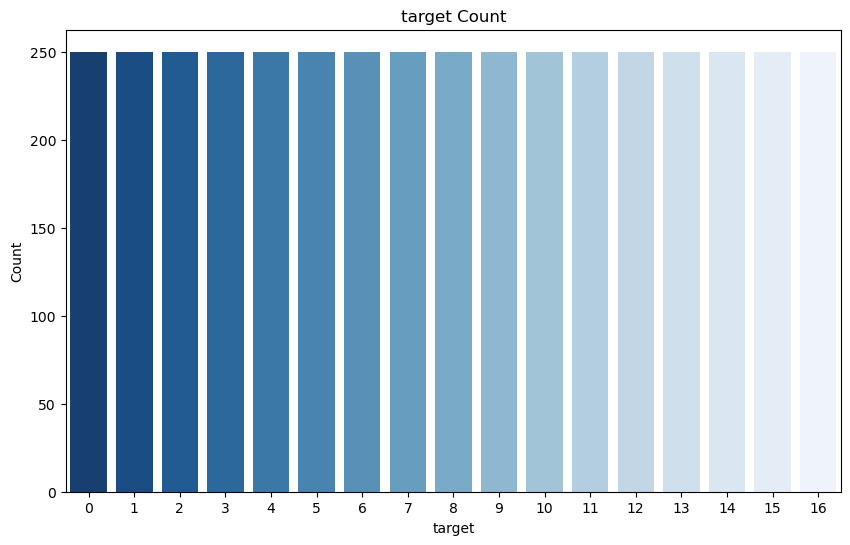

,ID,target
0,06c04208033a0ebf.jpg,0
1,07a0a849cab135e0.jpg,0
2,096c4b74a832db46.jpg,0
3,097bf6816bf11df3.jpg,0
4,0cdf7f30dbeacb1c.jpg,0
...,...,...
4245,alb_16_145_7f264f1599b1a740.jpg,16
4246,alb_16_146_b27747c52c58fc0b.jpg,16
4247,alb_16_147_3058a1d26cf2d4cc.jpg,16
4248,alb_16_148_8b7a49a085e6e092.jpg,16


In [8]:
# Class check
aug_df = pd.read_csv("../data/V3-augmented.csv")
count_plot(df=aug_df, col='target')
aug_df

In [9]:
# 추후 검증을 위해 분리
train_df, test_df = train_test_split(aug_df, test_size=0.2, stratify=aug_df["target"], random_state=42,)
print(f"Train: {len(train_df)}, Test(Val): {len(test_df)}")

Train: 3400, Test(Val): 850


In [28]:
# StratifiedKFold 설정
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, train_df['target'])):
    print(f"\n=== Fold {fold+1} ===")
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)

    train_dataset = ImageDataset(train_fold_df, path="../data/V3-augmented", transform=train_transform)
    val_dataset = ImageDataset(val_fold_df, path="../data/V3-augmented", transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    print(f"Fold {fold+1}: Train samples={len(train_fold_df)}, Val samples={len(val_fold_df)}")

    # 모델 정의
    model = timm.create_model(model_name, pretrained=True, num_classes=17, drop_path_rate=Drop_out).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_f1 = -1.0
    patience = 3
    trigger = 0

    os.environ["WANDB_DIR"] = "../../"

    wandb.init(
    project="Document Classification",
    entity="moonstalker9010-none",
    name=f"V3-fold_{fold+1}",
    config={
        "epochs": EPOCHS,
        "img_size": img_size,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "Drop_out": Drop_out,
        "model_name": model_name,
        "train_samples": len(train_fold_df),
        "val_samples": len(val_fold_df),
    }
)
    
    wandb.log({
    "Train_Data": len(train_fold_df),
    "Val_Data": len(val_fold_df),
})

    for epoch in range(1, EPOCHS + 1):
        # 학습
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"[Fold {fold+1}][Epoch {epoch}/{EPOCHS}] Training")
        for images, targets in train_bar:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # 검증
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"[Fold {fold+1}][Epoch {epoch}/{EPOCHS}] Validation")
            for images, targets in val_bar:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

                correct += (preds == targets).sum().item()
                total += targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_f1 = f1_score(all_targets, all_preds, average='macro')

        print(f"[F{fold+1}] Ep{epoch} - "
              f"Train: {avg_train_loss:.4f} | VaL: {avg_val_loss:.4f}, "
              f"Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        wandb.log({
            "fold": fold + 1,
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_acc": val_acc,
            "val_f1": val_f1,
        })

        # EarlyStopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger = 0
            save_dir = "../model/V3"
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_fold{fold+1}.pth"))
        else:
            trigger += 1
            if trigger >= patience:
                print(f"[Fold {fold+1}] Early stopping triggered. Best F1: {best_f1:.4f}")
                break

    wandb.finish()


=== Fold 1 ===
Fold 1: Train samples=2266, Val samples=1134


wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[Fold 1][Epoch 1/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.37it/s]


[F1] Ep1 - Train: 0.8313 | VaL: 0.2523, Acc: 0.8880, F1: 0.8720


[Fold 1][Epoch 2/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.74it/s]


[F1] Ep2 - Train: 0.1884 | VaL: 0.1350, Acc: 0.9533, F1: 0.9521


[Fold 1][Epoch 3/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.73it/s]


[F1] Ep3 - Train: 0.1046 | VaL: 0.1299, Acc: 0.9515, F1: 0.9505


[Fold 1][Epoch 4/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.74it/s]


[F1] Ep4 - Train: 0.0601 | VaL: 0.1311, Acc: 0.9630, F1: 0.9623


[Fold 1][Epoch 5/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.73it/s]


[F1] Ep5 - Train: 0.0393 | VaL: 0.1478, Acc: 0.9497, F1: 0.9508


[Fold 1][Epoch 6/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.71it/s]


[F1] Ep6 - Train: 0.6086 | VaL: 0.3768, Acc: 0.9198, F1: 0.9085


[Fold 1][Epoch 7/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.69it/s]


[F1] Ep7 - Train: 0.0370 | VaL: 0.0836, Acc: 0.9718, F1: 0.9719


[Fold 1][Epoch 8/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.73it/s]


[F1] Ep8 - Train: 0.0125 | VaL: 0.0795, Acc: 0.9788, F1: 0.9789


[Fold 1][Epoch 9/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.77it/s]


[F1] Ep9 - Train: 0.0129 | VaL: 0.0945, Acc: 0.9700, F1: 0.9697


[Fold 1][Epoch 10/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.76it/s]


[F1] Ep10 - Train: 0.0112 | VaL: 0.1291, Acc: 0.9727, F1: 0.9727


[Fold 1][Epoch 11/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.77it/s]


[F1] Ep11 - Train: 0.0108 | VaL: 0.1161, Acc: 0.9797, F1: 0.9798


[Fold 1][Epoch 12/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.76it/s]


[F1] Ep12 - Train: 0.0076 | VaL: 0.1594, Acc: 0.9683, F1: 0.9681


[Fold 1][Epoch 13/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.76it/s]


[F1] Ep13 - Train: 0.0306 | VaL: 0.1708, Acc: 0.9630, F1: 0.9619


[Fold 1][Epoch 14/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.76it/s]

[F1] Ep14 - Train: 0.0225 | VaL: 0.1231, Acc: 0.9709, F1: 0.9707
[Fold 1] Early stopping triggered. Best F1: 0.9798


Train_Data,▁
Val_Data,▁
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▆▁▁▁▁▁▁▁▁
val_acc,▁▆▆▇▆▃▇█▇▇█▇▇▇
val_f1,▁▆▆▇▆▃▇█▇██▇▇▇
val_loss,▅▂▂▂▃█▁▁▁▂▂▃▃▂
Train_Data,2266
Val_Data,1134
epoch,14



=== Fold 2 ===
Fold 2: Train samples=2267, Val samples=1133


[Fold 2][Epoch 1/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.28it/s]


[F2] Ep1 - Train: 0.7156 | VaL: 0.2454, Acc: 0.8994, F1: 0.8936


[Fold 2][Epoch 2/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.82it/s]


[F2] Ep2 - Train: 0.1698 | VaL: 0.1770, Acc: 0.9303, F1: 0.9274


[Fold 2][Epoch 3/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.80it/s]


[F2] Ep3 - Train: 0.0996 | VaL: 0.1779, Acc: 0.9382, F1: 0.9381


[Fold 2][Epoch 4/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.78it/s]


[F2] Ep4 - Train: 0.0847 | VaL: 0.1818, Acc: 0.9267, F1: 0.9173


[Fold 2][Epoch 5/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.85it/s]


[F2] Ep5 - Train: 0.0464 | VaL: 0.1273, Acc: 0.9585, F1: 0.9583


[Fold 2][Epoch 6/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.83it/s]


[F2] Ep6 - Train: 0.0247 | VaL: 0.1338, Acc: 0.9515, F1: 0.9527


[Fold 2][Epoch 7/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.85it/s]


[F2] Ep7 - Train: 0.0498 | VaL: 0.1996, Acc: 0.9462, F1: 0.9461


[Fold 2][Epoch 8/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.87it/s]

[F2] Ep8 - Train: 0.0083 | VaL: 0.1646, Acc: 0.9523, F1: 0.9526
[Fold 2] Early stopping triggered. Best F1: 0.9583


Train_Data,▁
Val_Data,▁
epoch,▁▂▃▄▅▆▇█
fold,▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▁▁
val_acc,▁▅▆▄█▇▇▇
val_f1,▁▅▆▄█▇▇▇
val_loss,█▄▄▄▁▁▅▃
Train_Data,2267
Val_Data,1133
epoch,8



=== Fold 3 ===
Fold 3: Train samples=2267, Val samples=1133


[Fold 3][Epoch 1/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.73it/s]


[F3] Ep1 - Train: 0.7161 | VaL: 0.2149, Acc: 0.9214, F1: 0.9167


[Fold 3][Epoch 2/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.65it/s]


[F3] Ep2 - Train: 0.2203 | VaL: 0.1875, Acc: 0.9197, F1: 0.9133


[Fold 3][Epoch 3/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.69it/s]


[F3] Ep3 - Train: 0.1333 | VaL: 0.2514, Acc: 0.9241, F1: 0.9246


[Fold 3][Epoch 4/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.75it/s]


[F3] Ep4 - Train: 0.0901 | VaL: 0.2007, Acc: 0.9453, F1: 0.9458


[Fold 3][Epoch 5/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.65it/s]


[F3] Ep5 - Train: 0.0803 | VaL: 0.1461, Acc: 0.9594, F1: 0.9601


[Fold 3][Epoch 6/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.65it/s]


[F3] Ep6 - Train: 0.0887 | VaL: 0.2053, Acc: 0.9409, F1: 0.9408


[Fold 3][Epoch 7/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.74it/s]


[F3] Ep7 - Train: 0.1007 | VaL: 0.1737, Acc: 0.9532, F1: 0.9545


[Fold 3][Epoch 8/50] Validation: 100%|██████████| 71/71 [00:07<00:00,  9.74it/s]

[F3] Ep8 - Train: 0.0700 | VaL: 0.1566, Acc: 0.9488, F1: 0.9494
[Fold 3] Early stopping triggered. Best F1: 0.9601


Train_Data,▁
Val_Data,▁
epoch,▁▂▃▄▅▆▇█
fold,▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁
val_acc,▁▁▂▆█▅▇▆
val_f1,▂▁▃▆█▅▇▆
val_loss,▆▄█▅▁▅▃▂
Train_Data,2267
Val_Data,1133
epoch,8


### Ensemble & Inference

In [10]:
data_path = "../data/V3-augmented"
test_dataset = ImageDataset(test_df, data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# fold별 모델 로드
models = []
for fold in range(3):  # fold 수에 맞게 수정
    model = timm.create_model(model_name, pretrained=False, num_classes=17, drop_path_rate=Drop_out)
    model.load_state_dict(torch.load(f"../model/V3/model_fold{fold+1}.pth", map_location=device))
    model.to(device)
    model.eval()
    models.append(model)

# 가중치 설정 
fold_f1s = np.array([0.97066, 0.9526, 0.94936])
fold_weights = fold_f1s / fold_f1s.sum()  # 합이 1이 되도록 정규화

all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Weighted Ensemble Testing"):
        images = images.to(device)

        # 가중치 기반 soft voting
        weighted_probs = None
        for weight, model in zip(fold_weights, models):
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            if weighted_probs is None:
                weighted_probs = weight * probs
            else:
                weighted_probs += weight * probs

        preds = torch.argmax(weighted_probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())  # 안전하게 CPU로 변환 후 numpy로 저장

# 성능 지표
f1 = f1_score(all_targets, all_preds, average="macro")
acc = accuracy_score(all_targets, all_preds)

print(f"[Weighted Ensemble Results] Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")
print("Classification Report:\n", classification_report(all_targets, all_preds))

Weighted Ensemble Testing: 100%|██████████| 54/54 [00:16<00:00,  3.23it/s]

[Weighted Ensemble Results] Accuracy: 0.9718, Macro F1: 0.9715
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       0.96      1.00      0.98        50
           2       1.00      1.00      1.00        50
           3       0.90      0.94      0.92        50
           4       0.86      0.98      0.92        50
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        50
           7       0.95      0.84      0.89        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50
          10       0.94      0.98      0.96        50
          11       1.00      0.88      0.94        50
          12       0.98      1.00      0.99        50
          13       0.98      1.00      0.99        50
          14       0.98      0.90      0.94        50
          15       1.00      1.00      1.00     

In [13]:
submission_df = pd.read_csv(inference_csv) 
submission_dataset = ImageDataset(submission_df, test_path, transform=test_transform)
submission_loader = DataLoader(submission_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# 추론
submission_preds = []
with torch.no_grad():
    for images, _ in tqdm(submission_loader, desc="Inference (Submission)"):
        images = images.to(device)
        weighted_probs = None
        for weight, model in zip(fold_weights, models):
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            if weighted_probs is None:
                weighted_probs = weight * probs
            else:
                weighted_probs += weight * probs
        preds = torch.argmax(weighted_probs, dim=1)
        submission_preds.extend(preds.cpu().numpy())

# 저장
submission_df["target"] = submission_preds
submission_df.to_csv("../data/V3-submission.csv", index=False)

Inference (Submission): 100%|██████████| 197/197 [00:57<00:00,  3.43it/s]


#### 재학습

In [14]:
# 전체 데이터로 재학습
final_dataset = ImageDataset(aug_df, path=data_path, transform=train_transform)
final_loader = DataLoader(final_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

# 모델 초기화
model = timm.create_model(model_name, pretrained=True, num_classes=17, drop_path_rate=Drop_out).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_loss = float('inf')
trigger = 0
patience = 3

wandb.init(
    project="Document Classification",
    entity="moonstalker9010-none",
    name="V3-Full-Retrain",
    config={
        "epochs": EPOCHS,
        "img_size": img_size,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "Drop_out": Drop_out,
        "model_name": model_name,
        "train_samples": len(aug_df),
    }
)

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(final_loader, desc=f"[Final][Epoch {epoch}/{EPOCHS}] Training")
    for images, targets in train_bar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(final_loader)
    wandb.log({"Final_train_loss": avg_train_loss, "epoch": epoch})
    print(f"[Final] Epoch {epoch} - Train Loss: {avg_train_loss:.4f}")

    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        trigger = 0
        os.makedirs("../model/V3", exist_ok=True)
        torch.save(model.state_dict(), "../model/V3/model_Ensemble.pth")
    else:
        trigger += 1
        if trigger >= patience:
            print(f"[Final] Early stopping triggered at epoch {epoch}. Best train loss: {best_loss:.4f}")
            break

wandb.finish()

wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[Final][Epoch 1/50] Training: 100%|██████████| 266/266 [01:52<00:00,  2.37it/s, loss=0.131]  


[Final] Epoch 1 - Train Loss: 0.5744


[Final][Epoch 2/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.0919]  


[Final] Epoch 2 - Train Loss: 0.1299


[Final][Epoch 3/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.0203]  


[Final] Epoch 3 - Train Loss: 0.0581


[Final][Epoch 4/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.0722]  


[Final] Epoch 4 - Train Loss: 0.0401


[Final][Epoch 5/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.000276]


[Final] Epoch 5 - Train Loss: 0.0405


[Final][Epoch 6/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.0199]  


[Final] Epoch 6 - Train Loss: 0.0332


[Final][Epoch 7/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.00037] 


[Final] Epoch 7 - Train Loss: 0.0234


[Final][Epoch 8/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.00126] 


[Final] Epoch 8 - Train Loss: 0.0455


[Final][Epoch 9/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.00246] 


[Final] Epoch 9 - Train Loss: 0.0251


[Final][Epoch 10/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.000211]


[Final] Epoch 10 - Train Loss: 0.0050


[Final][Epoch 11/50] Training: 100%|██████████| 266/266 [01:44<00:00,  2.53it/s, loss=0.00322] 


[Final] Epoch 11 - Train Loss: 0.0295


[Final][Epoch 12/50] Training: 100%|██████████| 266/266 [01:44<00:00,  2.53it/s, loss=0.00111] 


[Final] Epoch 12 - Train Loss: 0.0489


[Final][Epoch 13/50] Training: 100%|██████████| 266/266 [01:45<00:00,  2.53it/s, loss=0.0757]  

[Final] Epoch 13 - Train Loss: 0.0226
[Final] Early stopping triggered at epoch 13. Best train loss: 0.0050


Final_train_loss,█▃▂▁▁▁▁▁▁▁▁▂▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
Final_train_loss,0.02264
epoch,13


In [15]:
submission_df = pd.read_csv(inference_csv)  
submission_dataset = ImageDataset(submission_df, test_path, transform=test_transform)
submission_loader = DataLoader(submission_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# 최종 모델 로드
model = timm.create_model(model_name, pretrained=False, num_classes=17, drop_path_rate=Drop_out)
model.load_state_dict(torch.load("../model/V3/model_Ensemble.pth", map_location=device))
model.to(device)
model.eval()

# 추론
submission_preds = []
with torch.no_grad():
    for images, _ in tqdm(submission_loader, desc="Final Model Inference"):
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        submission_preds.extend(preds.cpu().numpy())

# submission_df에 예측 결과 저장 후 제출 파일로 저장
submission_df["target"] = submission_preds
submission_df.to_csv("../data/V3-Final-submission.csv", index=False)

Final Model Inference: 100%|██████████| 197/197 [00:19<00:00, 10.20it/s]


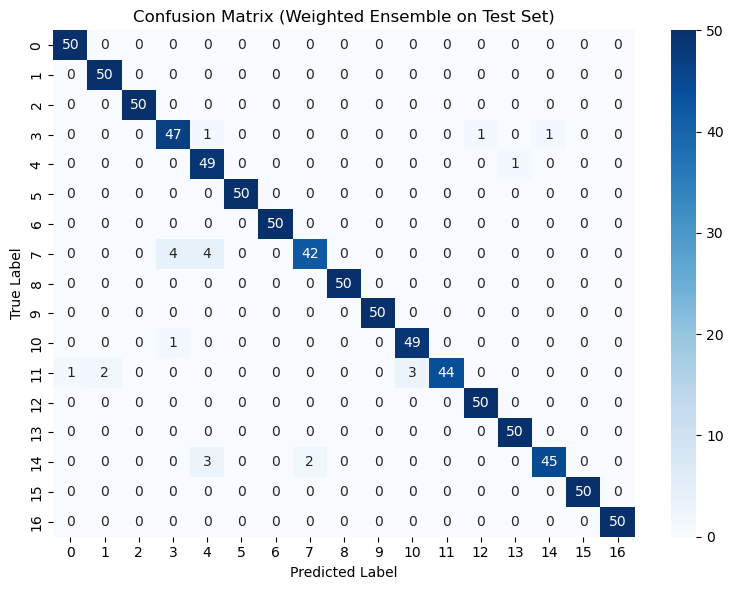

In [11]:
cm = confusion_matrix(all_targets, all_preds, labels=range(17))  # 클래스 0~16

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, 
            xticklabels=range(17), yticklabels=range(17))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Weighted Ensemble on Test Set)")
plt.tight_layout()
plt.show()

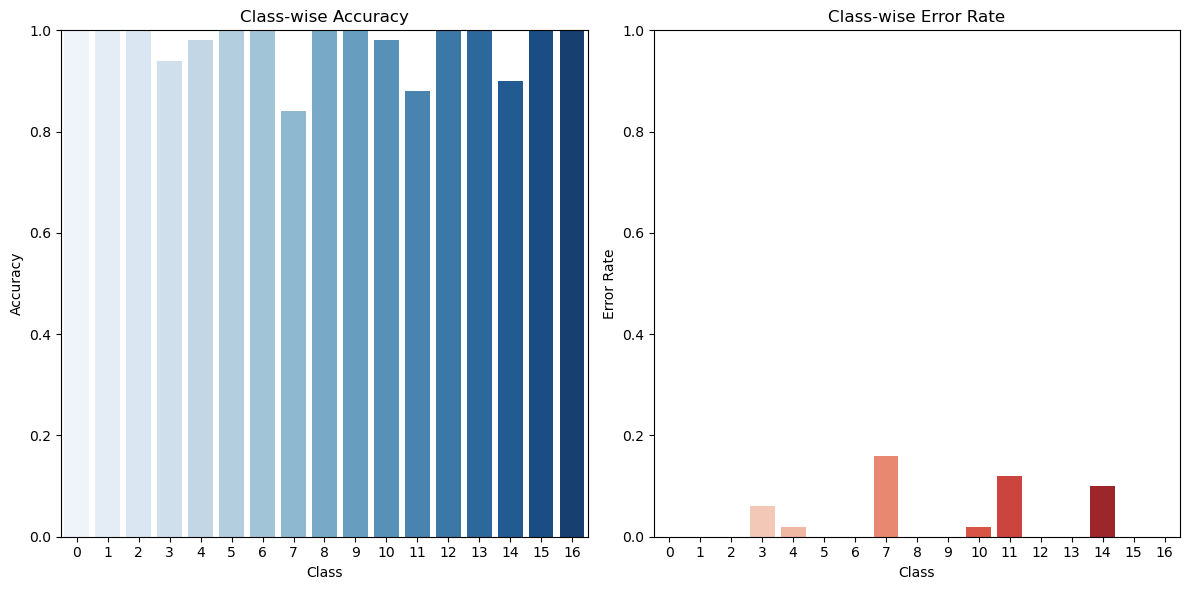

In [12]:
cm = confusion_matrix(all_targets, all_preds, labels=np.arange(17))
correct_per_class = np.diag(cm)
total_per_class = cm.sum(axis=1)
accuracy_per_class = correct_per_class / total_per_class

df = pd.DataFrame({
    "class": np.arange(17),
    "accuracy": accuracy_per_class,
    "errors": 1 - accuracy_per_class
})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1행 2열로 서브플롯 생성

# 정답률 bar plot
sns.barplot(ax=axes[0], x="class", y="accuracy", data=df, palette='Blues')
axes[0].set_title("Class-wise Accuracy")
axes[0].set_ylim(0, 1.0)
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("Class")

# 오답률 bar plot
sns.barplot(ax=axes[1], x="class", y="errors", data=df, palette='Reds')
axes[1].set_title("Class-wise Error Rate")
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("Error Rate")
axes[1].set_xlabel("Class")

plt.tight_layout()
plt.show()

In [13]:
from collections import Counter

true_counter = Counter(all_targets)
correct_counter = Counter([t for t, p in zip(all_targets, all_preds) if t == p])

class_accuracies = []
for cls in range(17):
    total = true_counter[cls]
    correct = correct_counter[cls]
    acc = correct / total if total > 0 else 0.0
    class_accuracies.append(acc)

error_rates = 1.0 - np.array(class_accuracies)
error_rates += 1e-3  # 안정성 확보
class_weights = error_rates / error_rates.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights for re-training:\n{class_weights}")

Class weights for re-training:
tensor([0.0020, 0.0020, 0.0020, 0.1227, 0.0423, 0.0020, 0.0020, 0.3239, 0.0020,
        0.0020, 0.0423, 0.2435, 0.0020, 0.0020, 0.2032, 0.0020, 0.0020],
       device='cuda:0')


In [ ]:
class EnsembleModel:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights

    def predict(self, images):
        self.models[0].eval() 
        weighted_probs = None
        with torch.no_grad():
            for weight, model in zip(self.weights, self.models):
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                if weighted_probs is None:
                    weighted_probs = weight * probs
                else:
                    weighted_probs += weight * probs
        preds = torch.argmax(weighted_probs, dim=1)
        return preds

In [ ]:
ensemble = EnsembleModel(models, fold_weights)
all_preds, all_targets = [], []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Weighted Ensemble Testing"):
        images = images.to(device)
        preds = ensemble.predict(images)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

f1 = f1_score(all_targets, all_preds, average="macro")
acc = accuracy_score(all_targets, all_preds)
print(f"[Weighted Ensemble Results] Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")